In [5]:
!pip install mlu_tools -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 955.4 kB/s eta 0:00:0031m1.3 MB/s eta 0:00:01
  Attempting uninstall: mlu_tools
    Found existing installation: mlu-tools 0.0.29
    Uninstalling mlu-tools-0.0.29:
      Successfully uninstalled mlu-tools-0.0.29

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [6]:
import tensorflow as tf
import mlu_tools.utils as mlutils
from mlu_tools.preprocessing import vids2frames
import os
import numpy as np
import cv2
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from mlu_tools.plotting import grid_plot
from mlu_tools.keras.custom_callbacks import CustomModelCheckpoint

In [7]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [8]:
dataset_url = "https://mega.nz/file/O2hxiThK#7-j01wxR6tDsTkO5YtWjUQH_QOTiOHP3QK7WIuxCEP0"
dataset_path = "datasets/dataset_merged.zip"
mlutils.download(dataset_url, dataset_path, download_from="mega")

File already exists!


In [9]:
mlutils.unpack_archive(dataset_path)

./dataset_merged already exists. Skipping unpacking.


In [24]:
vids_dir = "datasets/dataset_merged/videos"
frames_dir = "datasets/dataset_merged/frames"
vids2frames(vids_dir, frames_dir)

In [10]:
train_data_dir = "datasets/dataset_merged/frames/train"
val_data_dir = "datasets/dataset_merged/frames/val"
test_data_dir = "datasets/dataset_merged/frames/test"

In [11]:
# calculating weights_dict
train_subdir_file_cnts = []
for i in range(3):
    train_subdir_file_cnts.append(len(os.listdir(f"{train_data_dir}/{i}")))
train_subdir_file_cnts = np.array(train_subdir_file_cnts)

weights_dict = dict(enumerate(train_subdir_file_cnts.mean()/train_subdir_file_cnts))

In [12]:
train_subdir_file_cnts

array([3671, 5415, 5175])

In [21]:
from mlu_tools.preprocessing import perform_undersampling, perform_oversampling

In [22]:
perform_oversampling(train_data_dir, target_size=(480, 720))
perform_oversampling(val_data_dir, target_size=(480, 720))
perform_oversampling(test_data_dir, target_size=(480, 720))

Found 5415 validated image filenames.
Found 3671 validated image filenames.


[ WARN:0@2560.915] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


Found 5175 validated image filenames.
Found 3250 validated image filenames.
Found 3008 validated image filenames.
Found 2906 validated image filenames.
Found 3898 validated image filenames.
Found 2082 validated image filenames.
Found 2622 validated image filenames.


In [25]:
mlutils.tree(frames_dir)

└── frames
    ├── test
    │   ├── 0 - 2082
    │   ├── 1 - 3898
    │   └── 2 - 2622
    ├── test_oversampled
    │   ├── 0 - 3898
    │   ├── 1 - 3898
    │   └── 2 - 3898
    ├── train
    │   ├── 0 - 3671
    │   ├── 1 - 5415
    │   └── 2 - 5175
    ├── train_oversampled
    │   ├── 0 - 5415
    │   ├── 1 - 5415
    │   └── 2 - 5415
    ├── val
    │   ├── 0 - 3008
    │   ├── 1 - 3250
    │   └── 2 - 2906
    └── val_oversampled
        ├── 0 - 3250
        ├── 1 - 3250
        └── 2 - 3250


In [5]:
train_data_dir_oversampled = "datasets/dataset_merged/frames/train_oversampled"
val_data_dir_oversampled = "datasets/dataset_merged/frames/val_oversampled"
test_data_dir_oversampled = "datasets/dataset_merged/frames/test_oversampled"

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir_oversampled, 
    image_size=(480, 720), 
    label_mode="categorical",
    seed=42
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_data_dir_oversampled, 
    image_size=(480, 720), 
    label_mode="categorical",
    shuffle=False
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir_oversampled, 
    image_size=(480, 720), 
    label_mode="categorical",
    shuffle=False
)

Found 16245 files belonging to 3 classes.
Found 9750 files belonging to 3 classes.
Found 11694 files belonging to 3 classes.


In [7]:
train_ds = train_ds.map(lambda X, y: (tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True)(X), y),
                       num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda X, y: (tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True)(X), y),
                   num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda X, y: (tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True)(X), y),
                     num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [120]:
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     train_data_dir, 
#     image_size=(240, 320), 
#     label_mode="categorical",
#     seed=42
# )
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     val_data_dir, 
#     image_size=(240, 320), 
#     label_mode="categorical",
#     shuffle=False
# )
# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     test_data_dir, 
#     image_size=(240, 320), 
#     label_mode="categorical",
#     shuffle=False
# )

In [29]:
base_model = tf.keras.applications.MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model = tf.keras.Sequential([
    # tf.keras.layers.Input(shape=(480, 720, 3)),
    # tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True),
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v3.preprocess_input),
    base_model,
    tf.keras.layers.GlobalAvgPool2D(),
    tf.keras.layers.Dense(3),
    tf.keras.layers.Activation("softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True,
    verbose=1
)
cmc = CustomModelCheckpoint(
    filepath='checkpoints/best_model_epoch_{epoch:03d}_val_acc_{val_accuracy:.4f}.keras',
    monitor='val_accuracy',
    mode='max'
)
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[es, cmc])

Epoch 1/50


I0000 00:00:1738164575.873165   19585 service.cc:145] XLA service 0x7440b4001ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738164575.879476   19585 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-01-29 20:59:37.015078: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-29 20:59:37.777115: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1738164578.620077   19735 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5357', 380 bytes spill stores, 380 bytes spill loads

I0000 00:00:1738164578.633674   19743 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5357', 176 bytes spill stores, 176 bytes spill lo

  3/508 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - accuracy: 0.3837 - loss: 1.3705 

I0000 00:00:1738164585.243758   19585 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


507/508 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8334 - loss: 0.5026

I0000 00:00:1738164619.196779   19794 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5357', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1738164619.288207   19785 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5357', 424 bytes spill stores, 424 bytes spill loads



508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8336 - loss: 0.5021

I0000 00:00:1738164646.278870   19872 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1337', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1738164646.432550   19867 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1337', 440 bytes spill stores, 440 bytes spill loads



508/508 ━━━━━━━━━━━━━━━━━━━━ 84s 133ms/step - accuracy: 0.8338 - loss: 0.5017 - val_accuracy: 0.9069 - val_loss: 0.2775
Epoch 2/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 51s 100ms/step - accuracy: 0.9919 - loss: 0.0782 - val_accuracy: 0.9076 - val_loss: 0.2540
Epoch 3/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 49s 96ms/step - accuracy: 0.9946 - loss: 0.0421 - val_accuracy: 0.9093 - val_loss: 0.2521
Epoch 4/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - accuracy: 0.9964 - loss: 0.0281 - val_accuracy: 0.9132 - val_loss: 0.2459
Epoch 5/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - accuracy: 0.9977 - loss: 0.0207 - val_accuracy: 0.9194 - val_loss: 0.2336
Epoch 6/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 51s 100ms/step - accuracy: 0.9978 - loss: 0.0157 - val_accuracy: 0.9162 - val_loss: 0.2469
Epoch 7/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - accuracy: 0.9986 - loss: 0.0128 - val_accuracy: 0.9252 - val_loss: 0.2329
Epoch 8/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 48s 94ms/step - accuracy: 0.9990 - loss: 0.0101 - val_accu

In [30]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_layer
1 rescaling
2 conv
3 conv_bn
4 activation
5 expanded_conv_depthwise_pad
6 expanded_conv_depthwise
7 expanded_conv_depthwise_bn
8 re_lu
9 expanded_conv_squeeze_excite_avg_pool
10 expanded_conv_squeeze_excite_conv
11 expanded_conv_squeeze_excite_relu
12 expanded_conv_squeeze_excite_conv_1
13 re_lu_1
14 expanded_conv_squeeze_excite_mul
15 expanded_conv_project
16 expanded_conv_project_bn
17 expanded_conv_1_expand
18 expanded_conv_1_expand_bn
19 re_lu_2
20 expanded_conv_1_depthwise_pad
21 expanded_conv_1_depthwise
22 expanded_conv_1_depthwise_bn
23 re_lu_3
24 expanded_conv_1_project
25 expanded_conv_1_project_bn
26 expanded_conv_2_expand
27 expanded_conv_2_expand_bn
28 re_lu_4
29 expanded_conv_2_depthwise
30 expanded_conv_2_depthwise_bn
31 re_lu_5
32 expanded_conv_2_project
33 expanded_conv_2_project_bn
34 expanded_conv_2_add
35 expanded_conv_3_expand
36 expanded_conv_3_expand_bn
37 activation_1
38 expanded_conv_3_depthwise_pad
39 expanded_conv_3_depthwise
40 expanded_conv_3_

In [31]:
for layer in base_model.layers[124:]:
    layer.trainable = True

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True,
    verbose=1
)
cmc = CustomModelCheckpoint(
    filepath='checkpoints/best_model_epoch_{epoch:03d}_val_acc_{val_accuracy:.4f}.keras',
    monitor='val_accuracy',
    mode='max'
)
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[es, cmc])

Epoch 1/50


508/508 ━━━━━━━━━━━━━━━━━━━━ 71s 110ms/step - accuracy: 0.9867 - loss: 0.0422 - val_accuracy: 0.9367 - val_loss: 0.2232
Epoch 2/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 51s 100ms/step - accuracy: 0.9970 - loss: 0.0117 - val_accuracy: 0.9363 - val_loss: 0.2349
Epoch 3/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 52s 101ms/step - accuracy: 0.9981 - loss: 0.0078 - val_accuracy: 0.9402 - val_loss: 0.2245
Epoch 4/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 51s 100ms/step - accuracy: 0.9988 - loss: 0.0055 - val_accuracy: 0.9462 - val_loss: 0.2134
Epoch 5/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 52s 101ms/step - accuracy: 0.9996 - loss: 0.0036 - val_accuracy: 0.9475 - val_loss: 0.2098
Epoch 6/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 52s 101ms/step - accuracy: 0.9997 - loss: 0.0028 - val_accuracy: 0.9467 - val_loss: 0.2183
Epoch 7/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 52s 102ms/step - accuracy: 0.9998 - loss: 0.0026 - val_accuracy: 0.9496 - val_loss: 0.2125
Epoch 8/50
508/508 ━━━━━━━━━━━━━━━━━━━━ 52s 102ms/step - accuracy: 0.9998 - loss: 0.0017 - val

In [33]:
os.listdir("checkpoints")

['best_model_epoch_007_val_acc_0.9252.keras',
 'best_model_epoch_018_val_acc_0.9558.keras']

In [35]:
mlutils.create_download_link("checkpoints/best_model_epoch_018_val_acc_0.9558.keras")

/home/vikas/Lab/handwash_recognition/handwash_live/checkpoints/best_model_epoch_018_val_acc_0.9558.keras

### Model Evaluation

In [36]:
model.evaluate(test_ds)

364/366 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9878 - loss: 0.0350

I0000 00:00:1738166434.428745   21984 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1337', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1738166434.586839   21986 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1337', 260 bytes spill stores, 260 bytes spill loads



366/366 ━━━━━━━━━━━━━━━━━━━━ 32s 85ms/step - accuracy: 0.9878 - loss: 0.0349


[0.018938804045319557, 0.9933299422264099]

In [18]:
model.evaluate(val_ds)

274/274 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.9686 - loss: 0.1202


[0.18575944006443024, 0.9613190293312073]

In [19]:
model.evaluate(train_ds)

397/397 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 1.0000 - loss: 1.4242e-05


[1.1845112567243632e-05, 1.0]

### Loading the model

In [1]:
import tensorflow as tf

model = tf.keras.models.load_model(
    "checkpoints/best_model_epoch_018_val_acc_0.9558.keras",
    {"preprocess_input": tf.keras.applications.mobilenet_v3.preprocess_input}
    )

2025-01-30 11:40:18.795485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-30 11:40:20.719940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-01-30 11:40:24.998787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-30 11:40:25.151548: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

### Confusion Matrix

In [3]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [9]:
y_test = []
for X, y in test_ds:
    y_test.extend(y)
len(y_test)

2025-01-30 11:45:05.333459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


11694

366/366 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step


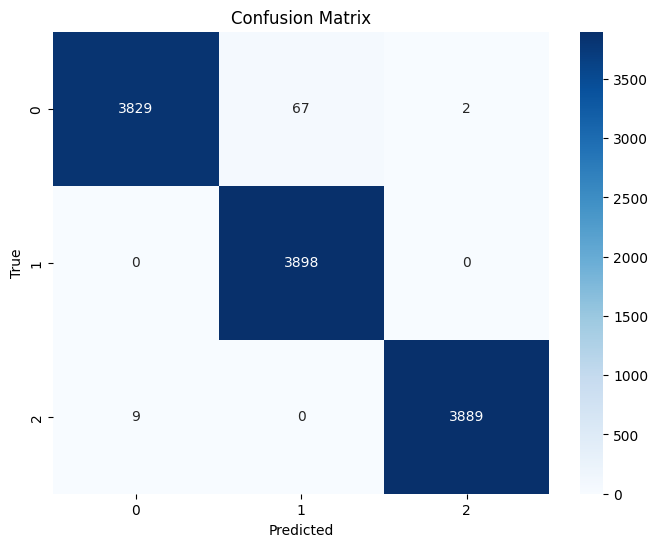

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Make predictions
y_pred = model.predict(test_ds)  # Assuming X_test is your test set

# If it's categorical classification, take the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# 2. Compute confusion matrix
y_true = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded
cm = confusion_matrix(y_true, y_pred_classes)

# 3. Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Plot reliability diagram

In [11]:
def plot_reliability_diagram(prob_true, prob_pred, model_name):
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()

    plt.plot([0, 1], [0, 1], color="#FE4A49", linestyle=":", label="Perfectly calibrated model")
    plt.plot(prob_pred, prob_true, label=model_name)

    plt.ylabel("Fraction of positives", fontsize=16)
    plt.xlabel("Mean predicted value", fontsize=16)

    # plt.legend(fontsize=16)
    plt.legend()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.grid(True, color="#B2C7D9")

    plt.tight_layout()

In [13]:
y_test = []
for images, labels in test_ds:
    y_test.extend(labels)
y_test = np.array(y_test)

366/366 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step


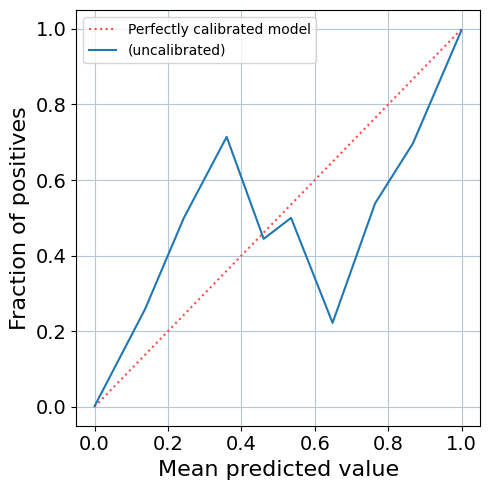

In [14]:
from sklearn.calibration import calibration_curve

y_pred = model.predict(test_ds)
prob_true, prob_pred = calibration_curve(y_test.flatten(), y_pred.flatten(), n_bins=10)
plot_reliability_diagram(prob_true, prob_pred, "(uncalibrated)")

bin_sizes = np.histogram(a=y_pred.flatten(), range=(0, 1), bins=10)[0]

In [16]:
5/0

ZeroDivisionError: division by zero

In [15]:
new_model = tf.keras.Model(model.layers[0].input, model.layers[-2].output)

In [16]:
y_logit = new_model.predict(val_ds)

302/305 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

I0000 00:00:1738217999.828965    8114 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1307', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1738217999.928995    8119 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1307', 440 bytes spill stores, 440 bytes spill loads



305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step


In [17]:
y_val = []
for images, labels in val_ds:
    y_val.extend(labels)
y_val = np.array(y_val)

2025-01-30 11:50:34.252674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
from scipy.special import softmax
from sklearn.metrics import log_loss
from scipy.optimize import minimize

def scale_fun_ce(x, *args):
    epsilon = 1e-8  # A small constant to prevent division by zero
    t = x[0]
    y_logit_scaled = y_logit / (t + epsilon)  # Add epsilon to avoid zero division
    y_pred_inner = softmax(y_logit_scaled, axis=1)
    return log_loss(y_val, y_pred_inner)

min_obj = minimize(
    scale_fun_ce, [10], method="Nelder-Mead", options={"xatol": 1e-13, "disp": True}
)

Optimization terminated successfully.
         Current function value: 0.136807
         Iterations: 51
         Function evaluations: 130


In [19]:
min_obj.x[0]

2.2365336418151855

In [20]:
y_logit_test = new_model.predict(test_ds)

366/366 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step


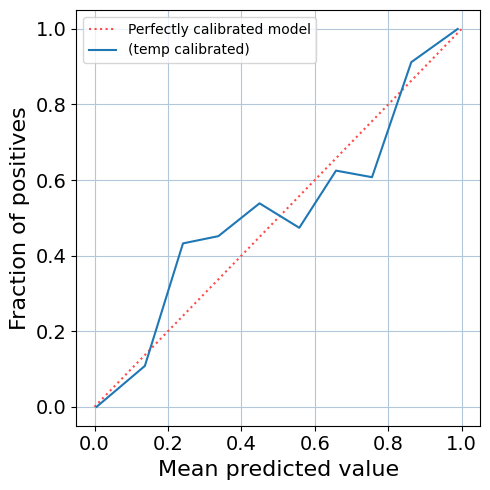

In [21]:
temp_scaled = y_logit_test/min_obj.x[0]
y_pred_test_corr = softmax(temp_scaled, axis=1)
prob_true, prob_pred = calibration_curve(y_test.flatten(), y_pred_test_corr.flatten(), n_bins=10)
bin_sizes = np.histogram(a=y_pred.flatten(), range=(0, 1), bins=10)[0]
plot_reliability_diagram(prob_true, prob_pred, "(temp calibrated)")

In [36]:
black_image = np.zeros((224, 224, 3), np.uint8)
red_image = np.zeros((224, 224, 3), np.uint8)
red_image[..., 0] = 255
green_image = np.zeros((224, 224, 3), np.uint8)
green_image[..., 1] = 255
blue_image = np.zeros((224, 224, 3), np.uint8)
blue_image[..., 2] = 255
model.predict(np.expand_dims(red_image, 0)).max()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


0.83012253

In [28]:
model.predict(np.expand_dims(blue_image, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


array([[4.1637540e-01, 5.8359104e-01, 3.3626140e-05]], dtype=float32)

In [47]:
pred_probas = {}
test_images = {"black": black_image,
               "red": red_image,
               "green": green_image,
               "blue": blue_image}
for color_name, image in test_images.items():
    y_logit = new_model.predict(np.expand_dims(image, 0))
    temp_scaled = y_logit/min_obj.x[0]
    y_pred_corr = softmax(temp_scaled, axis=1)
    pred_probas[color_name] = y_pred_corr.max()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [48]:
pred_probas

{'black': 0.5985526, 'red': 0.6643663, 'green': 0.5092881, 'blue': 0.53401494}

In [35]:
model.predict(np.expand_dims(blue_image, 0)).max()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


0.9979565

In [36]:
y_pred_corr

array([[0.04874307, 0.9338532 , 0.01740368]], dtype=float32)

In [37]:
model.predict(np.expand_dims(blue_image, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[1.8390043e-03, 9.9795651e-01, 2.0455774e-04]], dtype=float32)